In [1]:
import os
print(os.listdir("./input/"))

['Amazon', 'backup', 'Cook2012.csv', 'Cook2013.csv', 'df_items.csv', 'df_metadata.csv', 'df_reviews.csv', 'user_sim_matrix.pickle']


In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


# data visualisation and manipulation
import numpy as np
import pandas as pd
from matplotlib import style
import matplotlib.pyplot as plt 
import seaborn as sns

# Sklearn package for evaluating model performance
from sklearn import metrics

# Euclidean distance
from scipy import spatial

# import custom helper methods
from helpers.helper import (
    format_json,
    to_csv,
    load_metadata,
    load_reviews,
    load_pickle,
    save_pickle,
    clean_category,
    extract_digits,
    clean_also_buy,
    clean_also_view,
    clean_price,
    clean_metadata_df,
    load_dataframes,
    save_dataframes,
    n_times_rated_items,
    n_times_rated_users,
    get_num_user_ratings,
    train_test_split,
    get_sparsity,
    similarity,
    get_reviews,
    compute_correlation_dist,
    get_items_seen,
    create_reviewer_item_dict,
    compute_user_sim_matrix,
    recommend_items,
    predict_user_rating,
)

# Progressbar
import progressbar

# configuring plots
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

# Matplotlib config
%matplotlib inline

# creating an alias for timeit
%alias_magic t timeit

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [3]:
# Install simplejson
# !pip install simplejson
# !pip install progressbar

In [4]:
# Data description can be found at https://snap.stanford.edu/data/web-Amazon.html
z_metadata = "./input/Amazon/meta_Books.json.gz"
z_reviews = "./input/Amazon/Books_5.json.gz"

f_metadata = "./input/Amazon/meta_Books.json"
f_reviews = "./input/Amazon/Books_5.json"

CSV_METADATA = "./input/df_metadata.csv"
CSV_REVIEWS = "./input/df_reviews.csv"
CSV_ITEMS = "./input/df_items.csv"

In [5]:
# df_metadata = load_metadata(f_metadata)
# df_reviews = load_reviews(f_reviews)

In [6]:
# df_reviews.head()

In order to understand our data, we need to look at each variable and try to understand their meaning and relevance to this problem

In [7]:
# df_metadata.head()

In [8]:
# df_metadata = clean_metadata_df(df_metadata)

This better describes the feature we'd Rename the feature `Overall` to `rating` 

In [9]:
# load dataframes
df_metadata, df_reviews, df_items = load_dataframes(
    metadata_file=CSV_METADATA,
    reviews_file=CSV_REVIEWS,
    items_file=CSV_ITEMS
)

In [10]:
# save dataframes to file for backup
# save_dataframes()

## Monitoring Memory usage by dataframes

In [11]:
df_metadata.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934949 entries, 0 to 2934948
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   category   object 
 1   title      object 
 2   rank       object 
 3   also_buy   object 
 4   also_view  object 
 5   price      float64
 6   asin       object 
dtypes: float64(1), object(6)
memory usage: 1.7 GB


In [12]:
df_reviews.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27164983 entries, 0 to 27164982
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   rating          float64
 1   reviewerID      object 
 2   asin            object 
 3   unixReviewTime  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.9 GB


In [13]:
df_items.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704273 entries, 0 to 704272
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   asin        704273 non-null  object 
 1   avg_rating  704273 non-null  float64
 2   num_rating  704273 non-null  int64  
 3   title       704174 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 127.3 MB


## Visualizing ratings

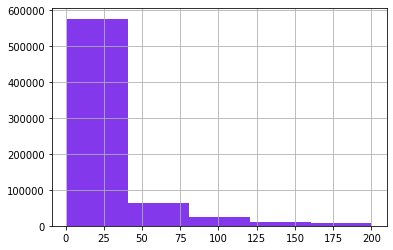

In [14]:
hist_num_rating = df_items.num_rating.hist(bins=5, range=(1, 200), color='#8338EC')

In [15]:
df_items.num_rating.max()

28975

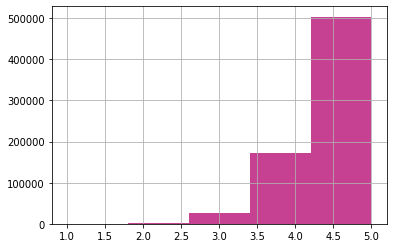

In [16]:
hist_avg_rating = df_items.avg_rating.hist(bins=5, label='Average rating', color='#C64191')

## Feature Engineering: 
Now we can try to pull relevant information out of the existing columns.

For each of the datasets, there are a couple of cleaning & feature engineering we would have to perform:

__Items__
- Remove users with less than 500 ratings

__Reviews__
- Remove review whose Id deosn't exist anymore 

In [17]:
# get number of ratings for each user
df_num_user_ratings = get_num_user_ratings(df_reviews)
# print the top 2 rows from the dataframe
df_num_user_ratings.sample(2)

,reviewerID,num_ratings
1846674,AZA4P71MTSJXB,5
725708,A2H9817X7Z56ZH,5


In [18]:
df_num_user_ratings.shape

(1856344, 2)

In [19]:
# shrink dataframes to include only data for >=500 ratings per user 
df_num_user_ratings, df_reviews, df_items, df_metadata = n_times_rated_users(
    df_num_user_ratings=df_num_user_ratings,
    min_ratings=500,
    df_reviews=df_reviews,
    df_items=df_items,
    df_metadata=df_metadata
)

In [20]:
# shrink dataframes to include only data for >=500 ratings per item
df_num_ratings, df_reviews, df_items, df_metadata = n_times_rated_items(
    min_ratings=500,
    df_reviews=df_reviews,
    df_items=df_items,
    df_metadata=df_metadata
)

In [21]:
df_reviews.reviewerID.nunique()

1542

In [22]:
df_reviews['asin'].nunique()

5427

In [23]:
df_items['asin'].nunique()

5427

In [24]:
df_metadata.shape

(5435, 7)

## Statistics

In [25]:
num_users = len(df_reviews['reviewerID'].unique())
num_items = len(df_reviews['asin'].unique())

# min and max ratings will be used to normalize the ratings later
min_rating = min(df_reviews["rating"])
max_rating = max(df_reviews["rating"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)

Number of users: 1542, Number of Items: 5427, Min rating: 1.0, Max rating: 5.0


## Split test/train sample set

In [26]:
train, test = train_test_split(df_reviews, seed=1, test_size=0.10)

 [Elapsed Time: 0:00:21] |###################################| (Time: 0:00:21) 


In [27]:
# train.reviewerID.nunique()

In [28]:
# save_pickle(train, 'train.pickle')
# save_pickle(test, 'test.pickle')

In [29]:
# train = load_pickle('./input/backup/train.pickle')
# test = load_pickle('./input/backup/test.pickle')

In [30]:
train.head()

,rating,reviewerID,asin,unixReviewTime
1560,3.0,A4SKIA2A7IDRX,0001720392,1.473984e+09
1575,5.0,ALYZJ7W14YS26,0001720392,1.469923e+09
1644,5.0,A1IYIOEZS24REF,0001720392,1.454803e+09
1704,5.0,A3OQWHOUM0U0QH,0001720392,1.440893e+09
1709,5.0,AZRPAHQG1VHR0,0001720392,1.439856e+09


In [31]:
test.head()

,rating,reviewerID,asin,unixReviewTime
319957,5.0,A4SKIA2A7IDRX,0007491557,1414281600
2263016,5.0,A4SKIA2A7IDRX,0141335734,1325808000
4976183,5.0,A4SKIA2A7IDRX,0356501558,1399593600
15206002,2.0,A4SKIA2A7IDRX,1480054542,1426636800
6382747,2.0,A4SKIA2A7IDRX,0425267067,1370044800


# Collaborative Filtering

__Similarity Based Methods__

Here we are going to go predict of items from users that have similar taste as our user

+ Measure user similarities
+ Predict user rating of items
+ Normalize the ratings

In [32]:
# df_reviews = train

## Creating pivot table using numpy's pivot method

In [33]:
# Creating pivot table using numpy's pivot method
%time reviewer_by_item = df_reviews.pivot_table(index='reviewerID', columns='asin', values='rating', aggfunc='mean', fill_value=0.0)
reviewer_by_item.head()

Wall time: 1.37 s


asin,000100039X,0001048767,0001050230,0001720295,0001720392,0001844423,0001945424,0001951076,0002005549,0002005883,...,B01CFIEXIY,B01CIYURJE,B01CSGVA8Y,B01ENNQ274,B01ENU0V5Q,B01FBZZNEG,B01FGM4H4Q,B01FMVUECK,B01FN30OBS,B01HB9Q7CW
reviewerID,,,,,,,,,,,,,,,,,,,,,
A103KWX1QFCG6I,0,0.0,0.0,0.0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A103M7E0BSFC83,0,0.0,0.0,0.0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A108M62RB1HTC0,0,0.0,0.0,0.0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1098Z3D7ENJ2F,0,0.0,0.0,0.0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10DX94ATZQEFG,0,0.0,0.0,0.0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### This is a peculiar case where a user has rated an item more than once

+ To handle such cases we'd get the 'mean' values across a user rating of a particular item
+ we also check to see wheter a user has rated an item above the 5.0 tier rating

In [34]:
df_reviews[df_reviews.reviewerID == 'A13G1TKIKHGV3F'][df_reviews.asin == '0001048767']

,rating,reviewerID,asin,unixReviewTime
17980,5.0,A13G1TKIKHGV3F,0001048767,1467417600
17985,5.0,A13G1TKIKHGV3F,0001048767,1467244800
18414,5.0,A13G1TKIKHGV3F,0001048767,1452470400
18428,4.0,A13G1TKIKHGV3F,0001048767,1452124800


In [35]:
df_reviews[df_reviews.rating > 5]

,rating,reviewerID,asin,unixReviewTime


In [36]:
# # Fill NaNs with zeros
# reviewer_by_item.fillna(0, inplace=True)
# reviewer_by_item.head()

## Calculate sparsity

_sparsity = num of null values/total num of values_

In [37]:
print('The percentage sparsity of the dataset is {:4.2f}%'.format(get_sparsity(reviewer_by_item, df_reviews)))


The percentage sparsity of the dataset is 1.58%


## Create User x User matrix

In [38]:
items_seen = create_reviewer_item_dict(reviewer_by_item, df_reviews)

 [Elapsed Time: 0:00:09] |###################################| (Time: 0:00:09) 


In [39]:
# Creating pivot table using numpy's pivot method

_user_by_user = pd.DataFrame()
_user_by_user['user_i'] = train['reviewerID'].unique()
_user_by_user['user_j'] = train['reviewerID'].unique()

_user_by_user.shape

(1542, 2)

In [40]:
# create user x user pivot table using pandas pivot_table
%time user_by_user = _user_by_user.groupby(['user_i','user_j']).apply(lambda x: 0).unstack()

Wall time: 19 ms


In [41]:
user_by_user.head(100)

user_j,A103KWX1QFCG6I,A103M7E0BSFC83,A108M62RB1HTC0,A1098Z3D7ENJ2F,A10DX94ATZQEFG,A10IKHRUSMKP46,A10LKYQ1D8LPK8,A10PEXB6XAQ5XF,A10RAGCKPARNMI,A10SXQMQBJ2L,...,AYYIRXRLL0FZF,AZD8SMNGQI98O,AZFENNBSMN980,AZGDIB6UL3QNL,AZK12FBX7X7LN,AZPMV1PM3ISSL,AZPXI8VOPVK2E,AZRPAHQG1VHR0,AZTFBJTENKT1T,AZULU4TOTOLEU
user_i,,,,,,,,,,,,,,,,,,,,,
A103KWX1QFCG6I,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103M7E0BSFC83,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A108M62RB1HTC0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1098Z3D7ENJ2F,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10DX94ATZQEFG,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A19I252AVVFU2S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A19I68RW4PBT29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A19KLUZ1XD3SRN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# user_by_user['A103KWX1QFCG6I']['A103KWX1QFCG6I']

In [43]:
# user_by_user.loc['A103KWX1QFCG6I','A108M62RB1HTC0']

In [44]:
# reviewer_by_item.reviewerID.iloc[u]

In [45]:
# users = np.array(df_reviews.reviewerID.unique())
# num_users = len(users)

In [46]:
# # Tests
# assert reviewer_by_item.shape[1] == df_items.shape[1], 'Oh no!, your matrix should have {} columns, and yours has {}'.format(df_items.shape[0], reviewer_by_item.shape[1])
# assert reviewer_by_item.reviewerID.nunique() == reviewer_by_item.shape[0], 'Oh no!, Your matrix should have {} rows, and yours has {}'.format(df_reviews.reviewerID.nunique(), reviewer_by_item.shape[0])
# print('All tests passed successfully')

## Testing correlation distribution 😁

In [47]:
user_1 = user_by_user.index[0]
user_2 = user_by_user.index[1]

print(user_1)
print(user_2)
compute_correlation_dist(user_1, user_2, items_seen, reviewer_by_item)

A103KWX1QFCG6I
A103M7E0BSFC83


0.0

In [48]:
%time compute_correlation_dist("A103KWX1QFCG6I", "A103M7E0BSFC83", items_seen, reviewer_by_item)

Wall time: 0 ns


0.0

In [49]:
%time compute_correlation_dist("A103KWX1QFCG6I", "A108M62RB1HTC0", items_seen, reviewer_by_item)

Wall time: 0 ns


0.0

In [ ]:
user_sim_matrix = compute_user_sim_matrix(user_by_user, items_seen, reviewer_by_item)

In [ ]:
user_sim_matrix.head()

In [ ]:
# recommend_items("A103KWX1QFCG6I", df_reviews.reviewerID.unique(), 10)

In [ ]:
# recommend_items("A103M7E0BSFC83", df_reviews.reviewerID.unique(), 10)

In [ ]:
# test[test.reviewerID == "A103KWX1QFCG6I"]

In [ ]:
# predict_user_rating(user_id = "A103KWX1QFCG6I", item_id = "1461072484", user_sim_matrix = user_sim_matrix, reviewer_by_item = reviewer_by_item)

In [ ]:
# user_sim_matrix.loc["A103KWX1QFCG6I"].values.sum()-1

In [ ]:
test_case = test

test_case['predicted_rating'] = test_case.apply(lambda x: predict_user_rating(
    user_id = x.reviewerID,
    item_id = x.asin,
    user_sim_matrix = user_sim_matrix,
    reviewer_by_item = reviewer_by_item
), axis=1)

In [ ]:
test_case.sample(10)

In [ ]:
metrics.mean_squared_error(test_case.rating, test_case.predicted_rating)

In [ ]:
metrics.precision_score(test_case.rating, test_case.predicted_rating.round(), average='micro')

In [ ]:
metrics.recall_score(test_case.rating, test_case.predicted_rating.round(), average='micro')